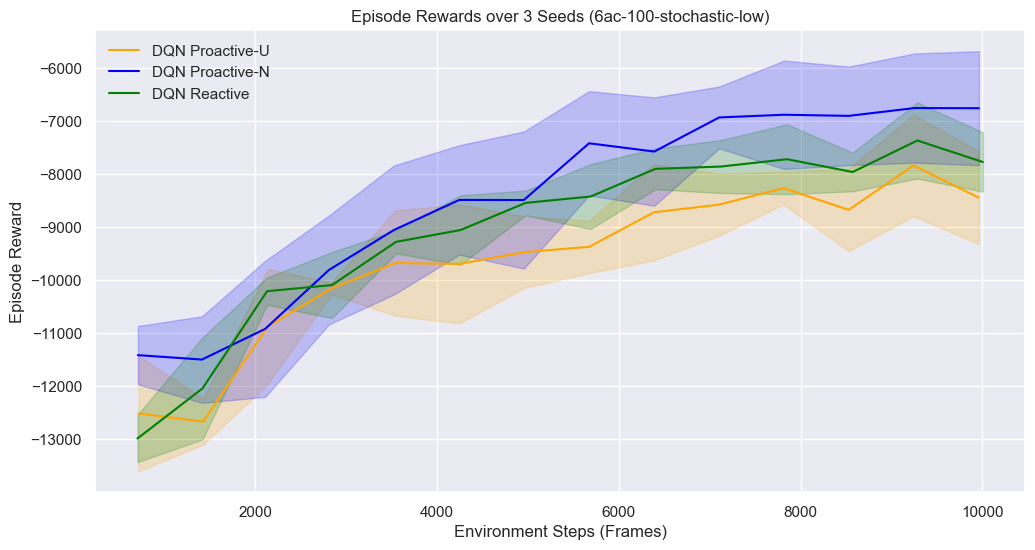

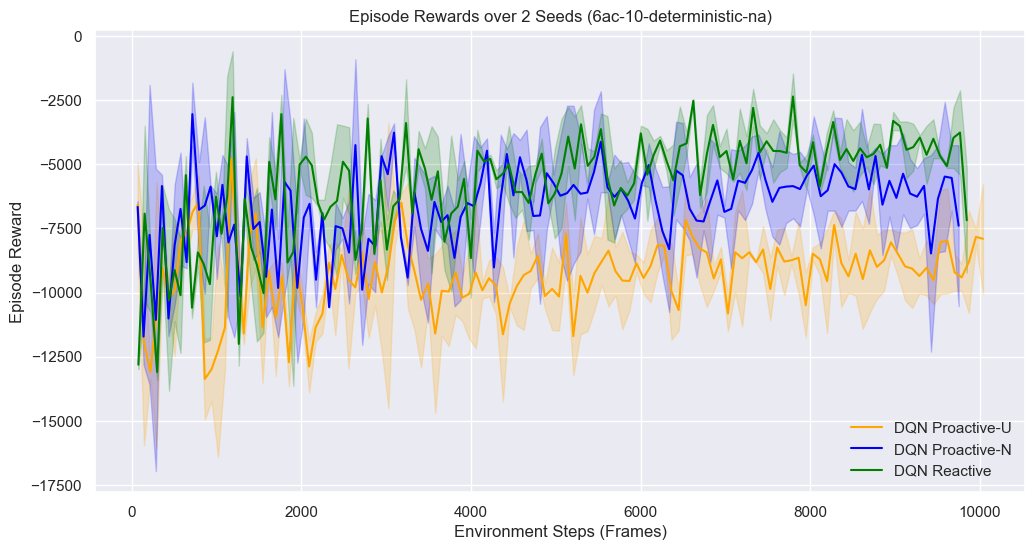

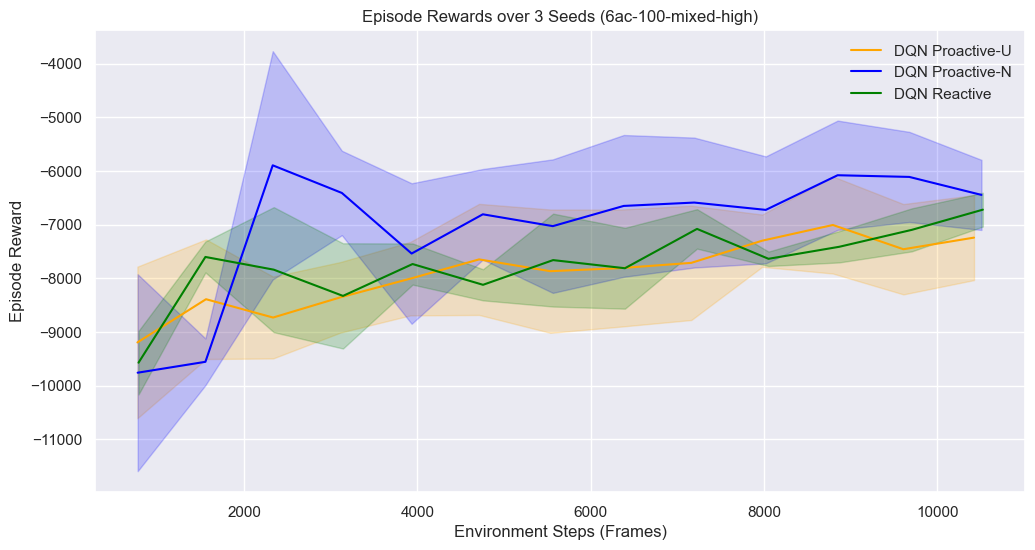

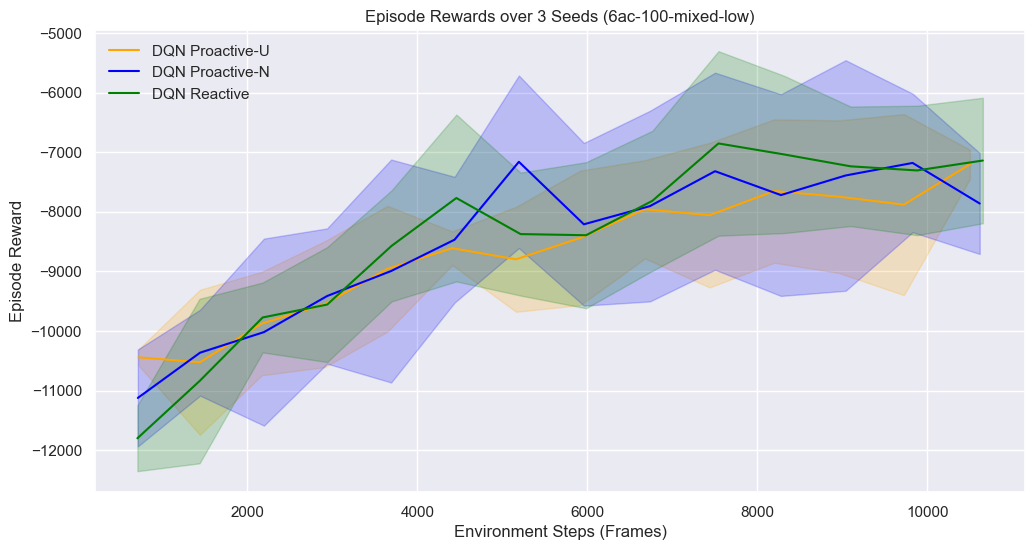

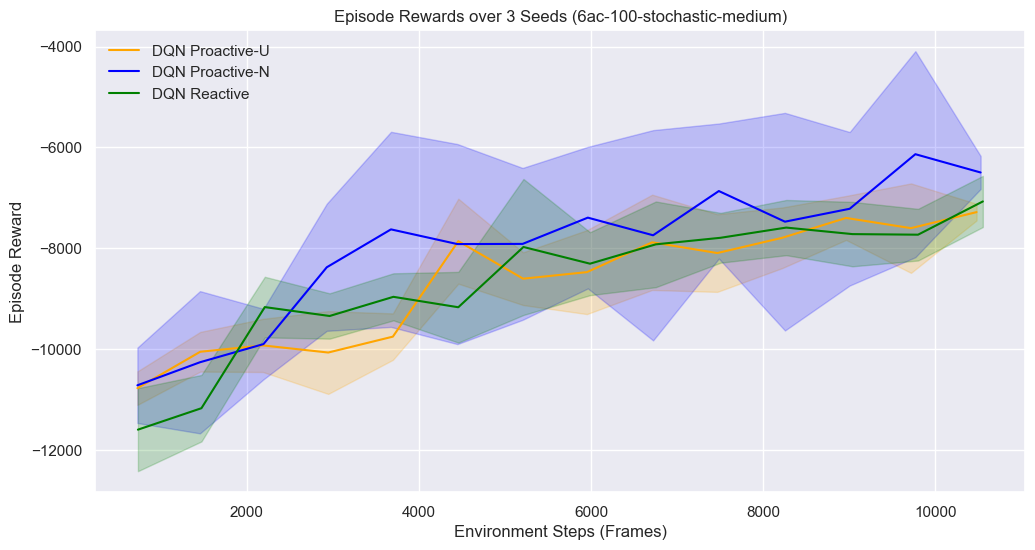

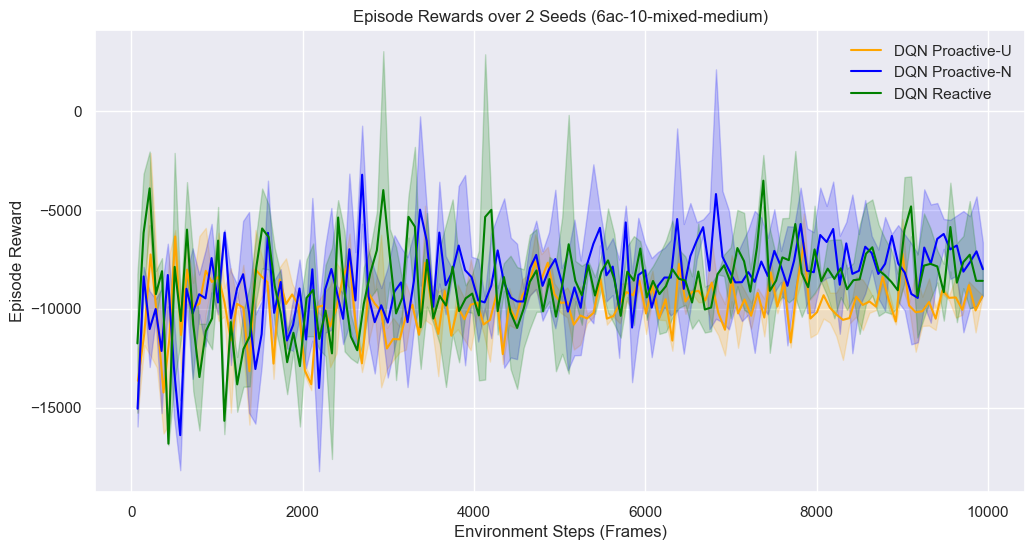

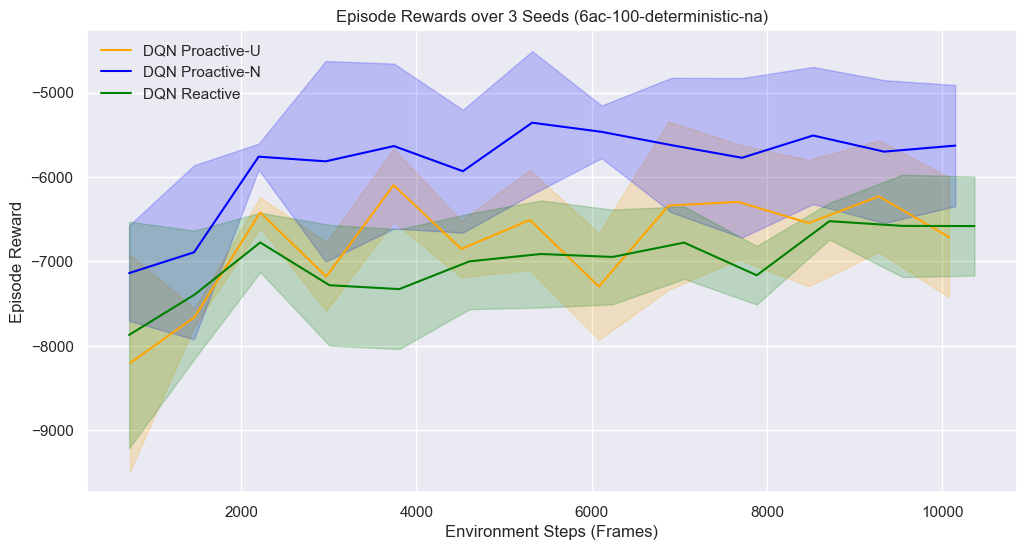

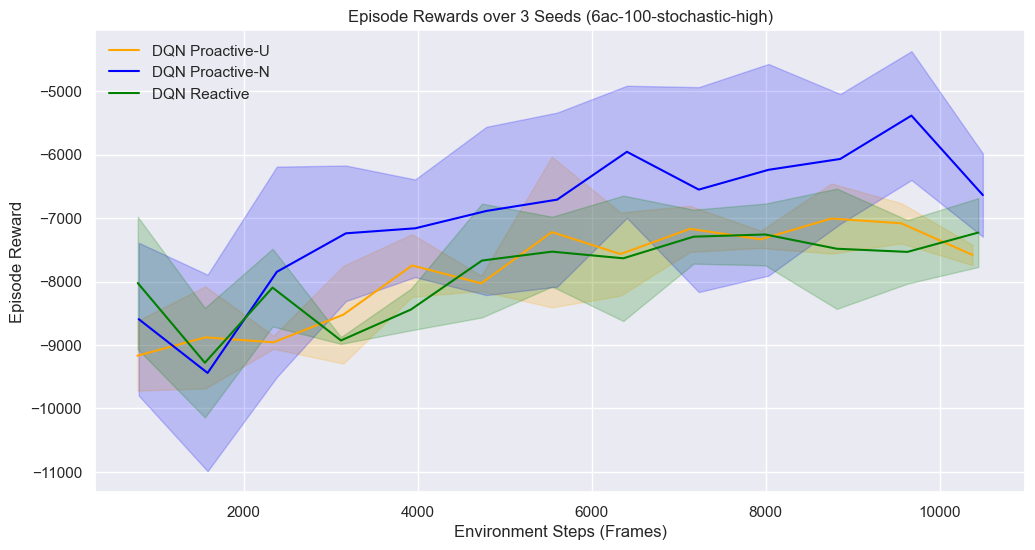

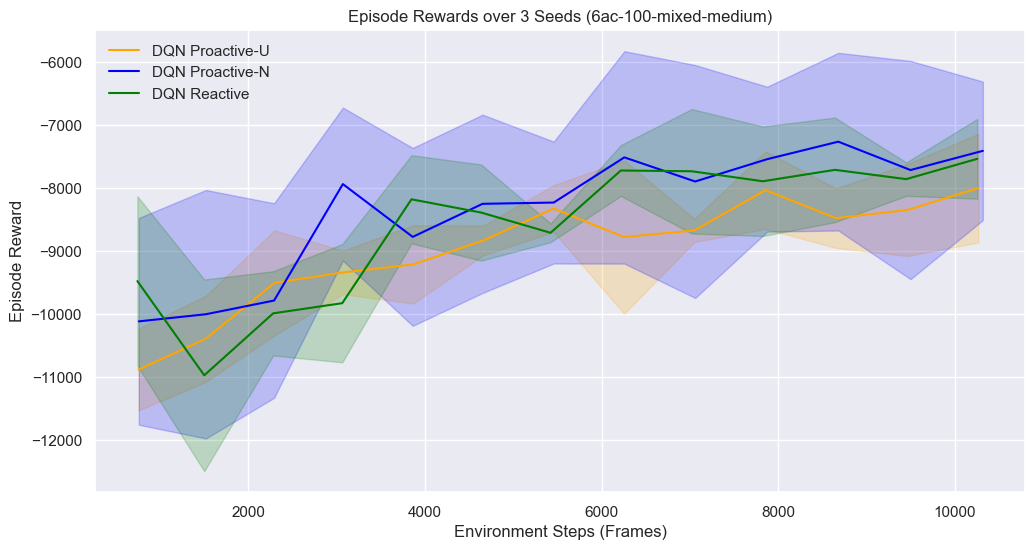

Done plotting all scenarios.


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_results_folder = "../6-big-run"  # folder containing scenario subfolders

def smooth(data, window=10):
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Scan the base folder for scenario subdirectories
scenario_folders = [
    f for f in os.listdir(base_results_folder) 
    if os.path.isdir(os.path.join(base_results_folder, f))
]

sns.set(style="darkgrid")

for scenario in scenario_folders:
    # Path to the numpy folder inside this scenario
    numpy_dir = os.path.join(base_results_folder, scenario, "numpy")
    if not os.path.exists(numpy_dir):
        # If there's no numpy folder, skip this scenario
        continue
    
    # Load the arrays
    try:
        all_myopic_runs = np.load(os.path.join(numpy_dir, "all_myopic_runs.npy"))
        all_myopic_steps_runs = np.load(os.path.join(numpy_dir, "all_myopic_steps_runs.npy"))
        all_proactive_runs = np.load(os.path.join(numpy_dir, "all_proactive_runs.npy"))
        all_proactive_steps_runs = np.load(os.path.join(numpy_dir, "all_proactive_steps_runs.npy"))
        all_reactive_runs = np.load(os.path.join(numpy_dir, "all_reactive_runs.npy"))
        all_reactive_steps_runs = np.load(os.path.join(numpy_dir, "all_reactive_steps_runs.npy"))
        
        # Test rewards might not exist if cross_val_flag was False
        test_rewards_myopic_path = os.path.join(numpy_dir, "all_test_rewards_myopic.npy")
        test_rewards_proactive_path = os.path.join(numpy_dir, "all_test_rewards_proactive.npy")
        test_rewards_reactive_path = os.path.join(numpy_dir, "all_test_rewards_reactive.npy")

        test_rewards_myopic = np.load(test_rewards_myopic_path) if os.path.exists(test_rewards_myopic_path) else None
        test_rewards_proactive = np.load(test_rewards_proactive_path) if os.path.exists(test_rewards_proactive_path) else None
        test_rewards_reactive = np.load(test_rewards_reactive_path) if os.path.exists(test_rewards_reactive_path) else None

    except FileNotFoundError as e:
        print(f"Missing files in {numpy_dir}, skipping scenario '{scenario}'. Error: {e}")
        continue

    # Compute means and std
    myopic_mean = all_myopic_runs.mean(axis=0)
    myopic_std = all_myopic_runs.std(axis=0)
    proactive_mean = all_proactive_runs.mean(axis=0)
    proactive_std = all_proactive_runs.std(axis=0)
    reactive_mean = all_reactive_runs.mean(axis=0)
    reactive_std = all_reactive_runs.std(axis=0)

    myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)
    proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)
    reactive_steps_mean = all_reactive_steps_runs.mean(axis=0).astype(int)

    # Smooth data for plotting (optional)
    smooth_window = 1
    myopic_mean_sm = smooth(myopic_mean, smooth_window)
    myopic_std_sm = smooth(myopic_std, smooth_window)
    myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

    proactive_mean_sm = smooth(proactive_mean, smooth_window)
    proactive_std_sm = smooth(proactive_std, smooth_window)
    proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

    reactive_mean_sm = smooth(reactive_mean, smooth_window)
    reactive_std_sm = smooth(reactive_std, smooth_window)
    reactive_steps_sm = reactive_steps_mean[:len(reactive_mean_sm)]

    # Plot averaged rewards over steps for this scenario
    plt.figure(figsize=(12,6))
    plt.plot(proactive_steps_sm, proactive_mean_sm, label="DQN Proactive-U", color='orange')
    plt.fill_between(proactive_steps_sm, 
                     proactive_mean_sm - proactive_std_sm, 
                     proactive_mean_sm + proactive_std_sm, 
                     alpha=0.2, color='orange')
    plt.plot(myopic_steps_sm, myopic_mean_sm, label="DQN Proactive-N", color='blue')
    plt.fill_between(myopic_steps_sm, 
                     myopic_mean_sm - myopic_std_sm, 
                     myopic_mean_sm + myopic_std_sm, 
                     alpha=0.2, color='blue')

    plt.plot(reactive_steps_sm, reactive_mean_sm, label="DQN Reactive", color='green')
    plt.fill_between(reactive_steps_sm, 
                     reactive_mean_sm - reactive_std_sm, 
                     reactive_mean_sm + reactive_std_sm, 
                     alpha=0.2, color='green')

    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    if len(all_myopic_runs) > 1:
        plt.title(f"Episode Rewards over {len(all_myopic_runs)} Seeds ({scenario})")
    else:
        plt.title(f"Episode Rewards ({scenario})")
    plt.legend(frameon=False)
    plt.grid(True)
    plt.show()

    # # If test rewards exist, plot them as well
    # if test_rewards_myopic is not None and len(test_rewards_myopic) > 0:
    #     # Just plot the first seed's test rewards for demonstration
    #     plt.figure(figsize=(12,6))
    #     plt.plot(test_rewards_myopic[0], label="Myopic", color='blue')
    #     plt.plot(test_rewards_proactive[0], label="Proactive", color='orange')
    #     plt.plot(test_rewards_reactive[0], label="Reactive", color='green')
    #     plt.xlabel("Episode")
    #     plt.ylabel("Test Reward")
    #     plt.title(f"Test Rewards over Episodes (DQN, {scenario})")
    #     plt.legend(frameon=False)
    #     plt.grid(True)
    #     plt.show()

print("Done plotting all scenarios.")


In [2]:
import sys
sys.path.append("..")
import os
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
import torch
import time
import re
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
from src.config import *

def run_inference_dqn(model_path, scenario_folder, env_type, seed):
    # Load scenario data
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict,
        env_type=env_type
    )

    # Load model
    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Reset the environment
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    # Start timing the inference
    start_time = time.time()

    while not done_flag and step_num < max_steps:
        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

        # Get action mask
        action_mask = obs.get('action_mask', None)
        if action_mask is None:
            raise ValueError("Action mask is missing in the observation!")

        # Get Q-values
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        # Mask invalid actions
        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        action = np.argmax(masked_q_values)

        # Step environment
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    # End timing
    end_time = time.time()
    runtime = end_time - start_time

    return total_reward, step_num, runtime


model_to_compare = [
    "../trained_models/dqn/6ac-100-stochastic-high/42/training_63/myopic-training_63.zip",
    "../trained_models/dqn/6ac-100-stochastic-high/42/training_64/proactive-training_64.zip",
    "../trained_models/dqn/6ac-100-stochastic-high/42/training_65/reactive-training_65.zip",
]

# Define the scenario folder set
SCENARIO_FOLDER = "../data/Testing/6ac-1000-stochastic-high/"

# Extract all scenario folders
scenario_folders = [os.path.join(SCENARIO_FOLDER, d) for d in os.listdir(SCENARIO_FOLDER) 
                    if os.path.isdir(os.path.join(SCENARIO_FOLDER, d)) and d.lower().startswith("scenario_")]
scenario_folders.sort()

def extract_env_type(model_path):
    match = re.search(r'/(myopic|proactive|reactive)_', model_path)
    return match.group(1) if match else "proactive"  # default to proactive if not found

# Create DataFrames to store results
results_df = pd.DataFrame(index=[os.path.basename(s) for s in scenario_folders],
                          columns=[os.path.basename(m) for m in model_to_compare])
runtime_df = pd.DataFrame(index=[os.path.basename(s) for s in scenario_folders],
                          columns=[os.path.basename(m) for m in model_to_compare])

# Set a seed for reproducibility
seed = int(time.time())

# Run inference for each scenario and each model
for scenario_folder in scenario_folders:
    for model_path in model_to_compare:
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")

        if not os.path.exists(scenario_folder):
            raise FileNotFoundError(f"Scenario folder not found: {scenario_folder}")

        env_type = extract_env_type(model_path)
        total_reward, steps, runtime = run_inference_dqn(model_path, scenario_folder, env_type, seed)
        
        scenario_name = os.path.basename(scenario_folder)
        model_name = os.path.basename(model_path)
        
        # Store the result in DataFrames
        results_df.loc[scenario_name, model_name] = total_reward
        runtime_df.loc[scenario_name, model_name] = runtime

# Convert to numeric
results_df = results_df.apply(pd.to_numeric, errors='coerce')
runtime_df = runtime_df.apply(pd.to_numeric, errors='coerce')

# Compute statistics
average_rewards = results_df.mean()
std_rewards = results_df.std()

average_runtime = runtime_df.mean()
std_runtime = runtime_df.std()

print("\nAverage reward over all scenarios for each model:")
print(average_rewards)

print("\nStandard Deviation of rewards for each model:")
print(std_rewards)

print("\nAverage runtime over all scenarios for each model:")
print(average_runtime)

print("\nStandard Deviation of runtime for each model:")
print(std_runtime)

# pairwise t-tests for rewards and runtime

model_names = results_df.columns
n_models = len(model_names)

print("\nPairwise p-values for REWARDS (based on paired t-tests):")
p_value_rewards = pd.DataFrame(index=model_names, columns=model_names)
for i in range(n_models):
    for j in range(n_models):
        if i == j:
            p_value_rewards.iloc[i, j] = np.nan
        else:
            # Paired t-test since it's the same set of scenarios
            stat, p_val = ttest_rel(results_df[model_names[i]], results_df[model_names[j]])
            p_value_rewards.iloc[i, j] = p_val
print(p_value_rewards)

print("\nPairwise p-values for RUNTIME (based on paired t-tests):")
p_value_runtime = pd.DataFrame(index=model_names, columns=model_names)
for i in range(n_models):
    for j in range(n_models):
        if i == j:
            p_value_runtime.iloc[i, j] = np.nan
        else:
            # Paired t-test
            stat, p_val = ttest_rel(runtime_df[model_names[i]], runtime_df[model_names[j]])
            p_value_runtime.iloc[i, j] = p_val
print(p_value_runtime)



Average reward over all scenarios for each model:
myopic-training_63.zip      -4790.2571
proactive-training_64.zip   -3521.0445
reactive-training_65.zip    -7623.2664
dtype: float64

Standard Deviation of rewards for each model:
myopic-training_63.zip       7882.639465
proactive-training_64.zip    8544.384501
reactive-training_65.zip     4609.902717
dtype: float64

Average runtime over all scenarios for each model:
myopic-training_63.zip       0.004771
proactive-training_64.zip    0.004596
reactive-training_65.zip     0.004114
dtype: float64

Standard Deviation of runtime for each model:
myopic-training_63.zip       0.001161
proactive-training_64.zip    0.001138
reactive-training_65.zip     0.000938
dtype: float64

Pairwise p-values for REWARDS (based on paired t-tests):
                          myopic-training_63.zip proactive-training_64.zip  \
myopic-training_63.zip                       NaN                  0.000406   
proactive-training_64.zip               0.000406             